## `Ali Almalki`
# Dog Breed Project 
## Classifying Different Dog Breeds in Images 🐶 

**`Project Source: `**

[Kaggle dog breed identification competition.](https://www.kaggle.com/c/dog-breed-identification/overview)



In [ ]:
#Unzip the uploaded data into Google Drive
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

# End-to-end Multi-class classification 

This notebook builds an end-to-end multi-class image classifier using TensorFlow library and TensorFlow Hub.

## 1. Problem Definition

Identifying the breed of a dog given an image of a dog. 

When I'm sitting at the park of my neighbourhood and I take a photo of a dog, I want to know what breed of dog it is. 


## 2. Dataset 

The dataset I'm using is from Kaggle's Dog Breed Identification competition. 

You can find the data through this link:
 https://www.kaggle.com/c/dog-breed-identification/data



## 3. Aim of the Project

The goal is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

**`Dataset information:`**

- There are various dog images in the train and test sets (unstructured data). I will use deep learning model to classify each dog breed in a given image. 

- There are 120 breeds of dogs (labels). 

- Training set: around 10,000+ images with labels.
- Test set: around 10,000+ images without labels and needs predicting its class label. 

In [ ]:
#Unzip the uploaded data into Google Drive
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

#### Import all required libraries for the project


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread # Import image read
import tensorflow as tf
import tensorflow_hub as hub # to pick a model that suits our problem
import os
import datetime
from sklearn.model_selection import train_test_split # to split the data into train, validation and test sets.
from IPython.display import display, Image # to view an image




In [ ]:
# Load TensorBoard notebook extenstion. We need tensorboard magic function later for tracking and visualising our model progress. 
%load_ext tensorboard 

In [ ]:
# TensorFlow version

tf.__version__

'2.7.0'

In [ ]:
# TensorFlow Hub version

hub.__version__

'0.12.0'

### Check if there is an access to a GPU?

In [ ]:
# Check for GPU availability

print('GPU', 'is available now ✅' if tf.config.list_physical_devices('GPU') else 'is not available ❌')


GPU is available now ✅


## Read the data
### Getting the data ready (Turning it into Tensors)

With all machine learning models, the data has to be in numerical format.
This is the first step which is turning the dog images into tensors (numerical representation). 

In [ ]:
# Read the data into a dataframe

labels_csv = pd.read_csv('/content/drive/MyDrive/Dog Vision/labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Labels shape 

labels_csv.shape

(10222, 2)

In [ ]:
# Labels general information 

labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,547d9b623cccf3a262db4b35f0c28e2c,scottish_deerhound
freq,1,126


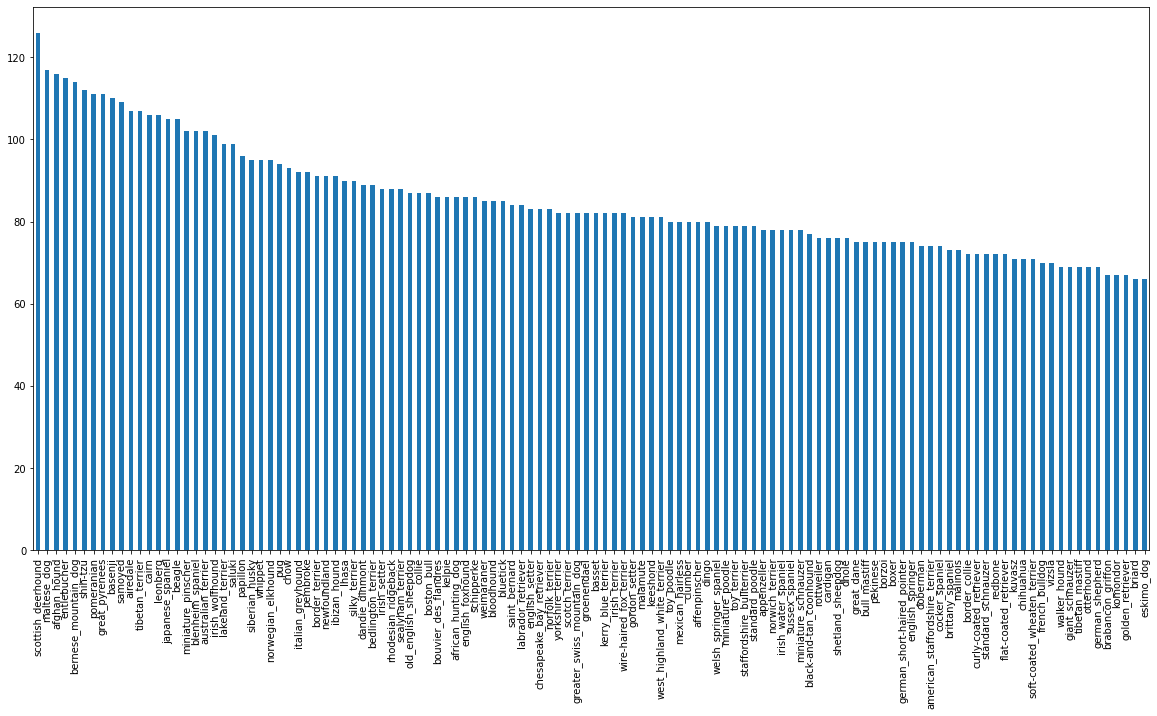

In [ ]:
# Check how many dogs in each breed 

labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
# Check the median number of images per class?

labels_csv['breed'].value_counts().median()

82.0

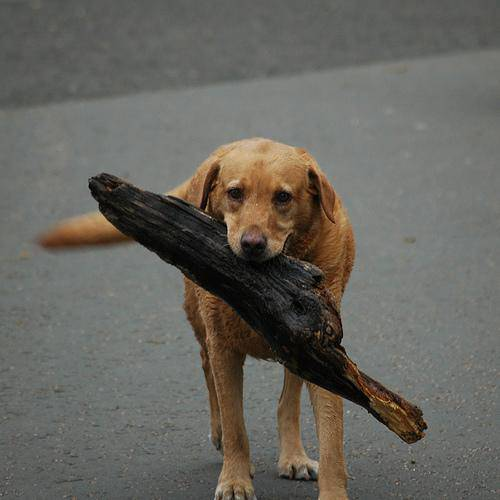

In [ ]:
# View a dog image

Image('/content/drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg')

### Getting images ID's and their corresponding labels

Here I want to create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [ ]:
# Getting images ID's 

filenames = ['drive/MyDrive/Dog Vision/train/'+fname+'.jpg' for fname in labels_csv['id']]

# Check the list

filenames[:5]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

#### Ok now I want to make sure that the number of files in the training set (10,222) equals the number of filenames path (The list I created above).


In [ ]:
# Check the length of actual image files in the training set and filenames path list

print(len(os.listdir('/content/drive/MyDrive/Dog Vision/train')))
print(len(filenames))

10222
10222


In [ ]:
# Check whether number of filenames matches number of actual image files

if len(os.listdir('/content/drive/MyDrive/Dog Vision/train')) == len(filenames):
  print('Success ✅ Filenames match actual amount of files')
else:
  print('Failure ❌ Filenames do not match actual amount of files')

Success ✅ Filenames match actual amount of files


In [ ]:
# Sample filename path
filenames[7]

'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg'

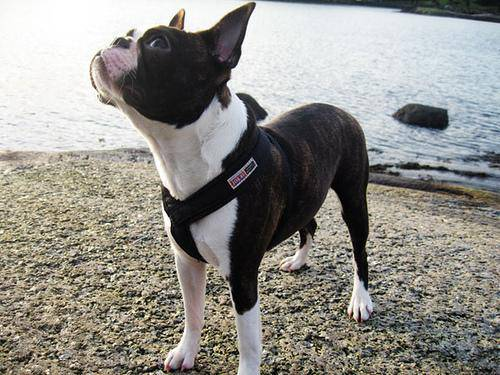

In [ ]:
# View an image from the filenames path

Image(filenames[324])


#### Now that I have image filepaths ready in a list (filenames), it's time to get the labels (breed) from (labels_csv) dataframe


In [ ]:
# Label = breed column (in labels_csv dataframe)
labels = labels_csv['breed']
labels = np.array(labels) # Turn it into a NumPy array
print(labels)

['boston_bull' 'dingo' 'pekinese' ... 'airedale' 'miniature_pinscher'
 'chesapeake_bay_retriever']


In [ ]:
len(labels)

10222

#### Convert the labels to numbers
##### to do this I'll do the following:
1- Get the unqiue label values <br>
2- After that, I'll go through the list of labels and compare them to unique label values and create a list of booleans indicating which one is the real label (True) and which ones aren't (False).

In [ ]:
# Find the unique label values

unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

### Turn the labels into numerical format 

In [ ]:
# Check: Turn a single array into an array of booleans 

print(labels[1])

labels[1] == unique_breeds

dingo


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Check the length of unique breeds 
len(unique_breeds)

120

In [ ]:
# Check the length of the labels
len(labels)

10222

In [ ]:
# Turn every label into a boolean array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Check the length of the boolean_labels
len(boolean_labels)

10222

In [ ]:
# Transforme a single dog breed name such as boston_bull into a one-hot array.

print(labels[0])
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[3])
print(boolean_labels[3].astype(int))

bluetick
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


So far I have:
- Prepared the labels into a numeric format (boolean_labels)
- Created a list for image filepaths (filenames)

#### Turn data into image filepaths `X` and labels `y`

In [ ]:
 # Set up X and y variables

 X = filenames # image filepaths
 y = boolean_labels # label (dog breed)

In [ ]:
# Check the type of X & y

print(type(X))
print(type(y))

<class 'list'>
<class 'list'>


#### I'm going to start off experimenting with 1000 images and increase as needed to make sure things are working before training on them all

In [ ]:
# Set number for images to use for experimenting

NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Split the data into train & validation sets

xtrain, xval, ytrain, yval = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=2)

# Check the length of the sets to make sure they're equal
len(xtrain), len(xval), len(ytrain), len(yval)


(800, 200, 800, 200)

In [ ]:
# Have a look on the training set
print(xtrain[:2]) # image filepaths
print(ytrain[:2]) # corresponding labels

['drive/MyDrive/Dog Vision/train/041d0d6a8d110b35a3795dd5c68f9a36.jpg', 'drive/MyDrive/Dog Vision/train/1418b4cd78095ff2635ef02684a026b7.jpg']
[array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fa

### Preprocess Images 

Here I need to turn the images filepaths into numerical format (Tensors). To preprocess our images into Tensors I'm going to write a function to do the following:

- Takes an `image` filename as input.
- Uses TensorFlow to read the file and save it to a variable `image`.
- Turn our `image` (a jpeg file) into Tensors.
- Resize the `image` to be of shape (224, 224) which represntes (height, width). We need images to be in this particular shape because this is the size of input that our model takes, an image which is (224, 224, 3). 3 here represents the number of colour channels per pixel (red, green and blue).
- Return the modified `image`.


In [ ]:
# Read in a sample image
image = imread(filenames[324])
image

array([[[244, 244, 242],
        [245, 245, 243],
        [245, 245, 243],
        ...,
        [ 13,  16,  23],
        [ 11,  14,  21],
        [ 10,  13,  20]],

       [[245, 245, 243],
        [245, 245, 243],
        [245, 245, 243],
        ...,
        [ 13,  16,  21],
        [ 12,  15,  20],
        [ 11,  14,  19]],

       [[245, 245, 243],
        [245, 245, 243],
        [245, 245, 243],
        ...,
        [ 15,  18,  23],
        [ 15,  18,  23],
        [ 15,  18,  23]],

       ...,

       [[148, 147, 129],
        [ 76,  75,  55],
        [ 31,  28,   9],
        ...,
        [ 88,  85,  92],
        [105, 102, 109],
        [108, 105, 112]],

       [[ 86,  85,  64],
        [ 96,  95,  74],
        [ 91,  89,  66],
        ...,
        [ 72,  67,  74],
        [ 86,  81,  88],
        [ 95,  90,  97]],

       [[ 65,  65,  41],
        [ 65,  65,  41],
        [105, 103,  78],
        ...,
        [ 43,  36,  44],
        [ 45,  38,  46],
        [ 63,  56,  64]]

In [ ]:
# Check the image shape 

image.shape

(375, 500, 3)

#### Convert the image into a Tensor

In [ ]:
tf.constant(image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[244, 244, 242],
        [245, 245, 243],
        [245, 245, 243],
        ...,
        [ 13,  16,  23],
        [ 11,  14,  21],
        [ 10,  13,  20]],

       [[245, 245, 243],
        [245, 245, 243],
        [245, 245, 243],
        ...,
        [ 13,  16,  21],
        [ 12,  15,  20],
        [ 11,  14,  19]],

       [[245, 245, 243],
        [245, 245, 243],
        [245, 245, 243],
        ...,
        [ 15,  18,  23],
        [ 15,  18,  23],
        [ 15,  18,  23]],

       ...,

       [[148, 147, 129],
        [ 76,  75,  55],
        [ 31,  28,   9],
        ...,
        [ 88,  85,  92],
        [105, 102, 109],
        [108, 105, 112]],

       [[ 86,  85,  64],
        [ 96,  95,  74],
        [ 91,  89,  66],
        ...,
        [ 72,  67,  74],
        [ 86,  81,  88],
        [ 95,  90,  97]],

       [[ 65,  65,  41],
        [ 65,  65,  41],
        [105, 103,  78],
        ...,
        [ 43,  36,  4

#### Write a function for image processing

In [ ]:
# Set image shape
IMG_SIZE = 224

def process_image(image_path):

    """

    This function takes an image file path and turns it into a Tensor.

    """

    # Read in image file

    image = tf.io.read_file(image_path)

    # Turn the jpeg image into a Tensor with three colour channels (Red, Blue and Green)

    image = tf.image.decode_jpeg(image, channels=3)

    # Convert the colour channel values from 0-255 to 0-1 values

    image = tf.image.convert_image_dtype(image, tf.float32)

    # Set the image size to be (224, 224)

    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image










#### Turn data into TensorFlow batches (32 `images, labels` -  the default batch size)

Here we want to compute one batch at a time to make the computation process more efficient.

In [ ]:
# Create a function to return (image, label)

def get_image_label(image_path, label):
  """

  This function takes an image file path names and their corresponding label, 
  process the image and returns a tuple of (image, label).

  """

  image = process_image(image_path)
  return image, label

#### Create a function for `Data Batches`

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  This function Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

#### Creating training and validation data batches 

In [ ]:
train_data = create_data_batches(xtrain, ytrain)
val_data = create_data_batches(xval, yval, valid_data=True)

Creating training data batches...
Creating validation data batches...


### Visualise data batches

In [ ]:
# Create a function for viewing images in a data batch
def show_15_images(images, labels):
  """
  Displays a plot of 15 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 15 images)
  for i in range(15):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
# Check out the different attributes of data batches
print(train_data.element_spec)
print(val_data.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))


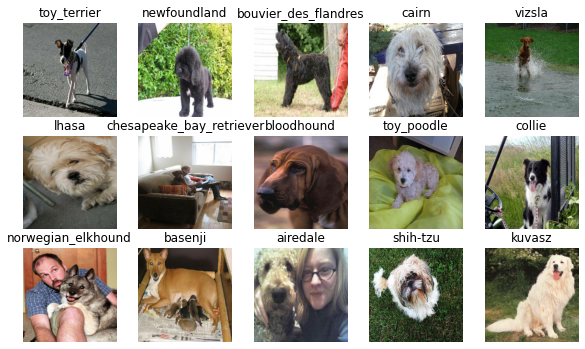

In [ ]:
#  Visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_15_images(train_images, train_labels)

In [ ]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

### Modelling Part

The model I will use from TensorFlow Hub can be found here - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

- First, we need to set the image size to be (224, 224, 3) (height, width, colour channels). This is because our deep learning model from keras has been trained on images with this shape.

- Second, we need to set output shape of our model to be equal to the number of class labels (120 dog breed). 

- Third, use the model from TensorFlow Hub.

In [ ]:
# First, Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels


In [ ]:
# Second, Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds) # 120 dog breed which is the amount of unique labels that we have


In [ ]:
# Finally, Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


In [ ]:
# Check input shape, output shape and the model
print('Default batch input shape:', INPUT_SHAPE)
print(OUTPUT_SHAPE)
print(MODEL_URL)

Default batch input shape: [None, 224, 224, 3]
120
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


#### Write a function to build a Keras model

I am going to use a sequential model instead of a functional model because it is appropriate for our case where we have one input tensor and one output tensor.

### Essential steps in building a deep learning model:
- Define the model as some sort of layers. 
- Define how the model is going to learn:
 - Here we have the loss function which we try to minimise to make the model learn better. Since we have a multi-class classification problem I will be using Categorical Cross entropy loss function.
 - Optimizer: an algorithm to reduce the losses hence get more accurate results. In this project I will use Adam optimization algorithm.

In [ ]:
def build_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE,
                model_url=MODEL_URL):
  """
  This function creates a Keras Sequential model with layers
  and returns the model
  """

  print('Building MobileNet V2 model:', MODEL_URL)
# Instantiate keras model with layers

  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), # This is the first layer (input layer)
                            tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation='softmax')])  # This is the second layer (output layer)

# Compile the model

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'
              ])

# Build the model

  model.build(INPUT_SHAPE) # Batch input shape ([None, 224, 224, 3])

  return model  # Return the model
  



In [ ]:
model = build_model()
model.summary()

Building MobileNet V2 model: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


#### Write a function to create a TensorBoard callback
The reason for this is to track model progress and stop training early if a model stops improving.



In [ ]:
def build_callback():
  """
  This function creates a TensorBoard callback.
  """
  
  logdir = os.path.join("drive/My Drive/Dog Vision/logs", # Create a log directory for storing TensorBoard logs
                        
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # Make it so the logs get tracked whenever we run an experiment
  return tf.keras.callbacks.TensorBoard(logdir)

#### Create Early Stopping Callback 
Here we want to create an early stopping callback to prevent our model from overfitting.

It does this by stopping the model training when a monitored metric has stopped improving.

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

### Model Training Part

Here we want to train our MobileNet image classification deep learning model deep learning model on a subset of the data (1000 images) to make sure everything is working fine.

In [ ]:
# Interactive variable for the number of epochs
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a function to train our model 

def train_model():
   """
   This function trains a given model and returns the trained version of the model.
   """

   # Build the model with layers 
   model = build_model()

   # Create a TensorBoard session to track model training 
   tensorboard = build_callback()

   # Fit the model to the data 

   model = model.fit(x=train_data,
                     epochs=NUM_EPOCHS,
                     validation_data=val_data, 
                     validation_freq=1,
                     callbacks=[tensorboard, early_stopping])
   
   # Return the trained version of the model
   return model
 

In [ ]:
# Check out the training and validation sets 
print(train_data)
print(val_data)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>


In [ ]:
# Fit the model to the data

model = train_model()


Building MobileNet V2 model: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 127s 5s/step - loss: 4.6623 - accuracy: 0.0913 - val_loss: 3.2041 - val_accuracy: 0.2950


### Check out the model performance with TensorBoard logs

In [ ]:
# Use the magic function %tensorboard to visualise how our experiment its going
%tensorboard --logdir /content/drive/MyDrive/Dog\ Vision/logs

In [ ]:
# Check out the training and validation batch datasets 
print(train_data)
print(val_data)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>


### Model predictions on the validation set

In [ ]:
# Check validation set

print(val_data)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>


In [1]:
pred = model.predict(val_data, verbose=1) # verbose to show the progress
pred

In [ ]:
# Checkout the predictions shape 
print(pred.shape)

In [ ]:
# Check a sample from predictions 
print(pred[1]) # 120 probabilities for each dog breed classe
print(len(pred[1])) # 120 label class

In [ ]:
# Choose any class probability prediction index (can be changed to any index to check)
index = 25 

In [ ]:
# Display sample prediction information
print(pred[index])
print(f'Max value of all probabilities of the prediction array: {np.max(pred[index])}')
print(f'Sum of all probabilities predictions: {np.sum(pred[index])}') 
print(f'Max index in probabilities predictions array: {np.argmax(pred[index])}')
print(f'Predicted label of the max index: {unique_breeds[np.argmax(pred[index])]}')

#### Write a small function to return prediction probabilities to their coressponding labels

In [ ]:
# Check unique breed labels 
unique_breeds

In [ ]:
def get_pred_label(predictions_probabilities):
  """
  This function returns predicted label based on an array of prediction probabilities.
  """

  return unique_breeds[np.argmax(predictions_probabilities)]

In [ ]:
# Test the function on a given prediction probability 
get_pred_label(pred[35])

#### Unbatchify dataset

In [ ]:
def unbatchify(data):
  """
  This function unbatchify a batched dataset. It takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """

  images=[]
  labels=[]

  #Loop through unbatched dataset
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels



In [ ]:
val_data

In [ ]:
# Test the unbatchify function on the validation set
val_images, val_labels = unbatchify(val_data)
val_images[2], val_labels[2]

#### Write a function to visualise the predicted label, its predicted probability, the truth label and the target image.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  This function takes an array of prediction probabilities, an array of truth labels 
  and an array of images and an integer 
  and plot the predicted label, its predicted probability, the truth label 
  and the target image on a single plot.
  """

  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the prediction label
  pred_label = get_pred_label(pred_prob)

  # Plot image 
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right (green) or wrong (red)
  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)


In [ ]:
# Check lengths are equal
print(len(val_images))
print(len(val_labels))
print(len(pred))

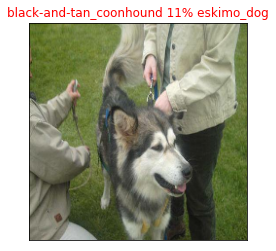

In [ ]:
# Check prediction of index 25
plot_pred(prediction_probabilities=pred,
          labels=val_labels,
          images=val_images,
          n=45) # n = index

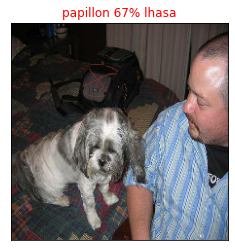

In [ ]:
# Check prediction of index say 85
plot_pred(prediction_probabilities=pred,
          labels=val_labels,
          images=val_images,
          n=85) # n = index

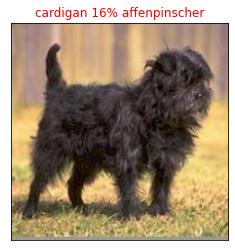

In [ ]:
# Check prediction of index say 95 and let's hope this time it's a correct prediction 😆
plot_pred(prediction_probabilities=pred,
          labels=val_labels,
          images=val_images,
          n=5) # n = index

## References: 
- Loading and saving data on Google Colab: https://colab.research.google.com/notebooks/io.ipynb
- Preparing images data: https://cloud.google.com/vision/automl/object-detection/docs/prepare
- Loading and preprocessing images: https://www.tensorflow.org/tutorials/load_data/images
- TensorFlow Hub pre-trained models: https://tfhub.dev/
- Keras Sequential model: https://www.tensorflow.org/guide/keras/sequential_model
- TensorBoard Callback: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
- EarlyStopping Callback: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- Unbatch a batche dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch
- Saving and loading models: https://www.tensorflow.org/tutorials/keras/save_and_load